<a href="https://colab.research.google.com/github/yassminyasser491-cyber/Teeth-Classification/blob/main/Task_1_Teeth_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================
# STEP 1: Upload and Extract Dataset
# ==============================
from google.colab import files
import zipfile, os

print("📂 Please upload Teeth DataSet.zip")
uploaded = files.upload()

zip_path = list(uploaded.keys())[0]
extract_path = "/content/Teeth_Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Dataset extracted to: {extract_path}")
os.listdir(extract_path)

📂 Please upload Teeth DataSet.zip


Saving Teeth DataSet.zip to Teeth DataSet.zip
✅ Dataset extracted to: /content/Teeth_Dataset


['Teeth_Dataset']

In [3]:


# ==============================
# STEP 2: Load Train/Val/Test Sets (force RGB)
# ==============================
import tensorflow as tf
from tensorflow import keras

train_dir = os.path.join(extract_path, "Teeth_Dataset/Training")
val_dir   = os.path.join(extract_path, "Teeth_Dataset/Validation")
test_dir  = os.path.join(extract_path, "Teeth_Dataset/Testing")

img_size = (128, 128)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_size, color_mode="rgb"
)
class_names = train_ds.class_names
print("📌 Classes:", class_names)

val_ds = keras.utils.image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_size, color_mode="rgb"
)

valid_classes = set(class_names)
all_folders = os.listdir(test_dir)
extra_folders = [f for f in all_folders if f not in valid_classes]

for f in extra_folders:
    path_to_remove = os.path.join(test_dir, f)
    if os.path.isdir(path_to_remove):
        !rm -r "{path_to_remove}"
    else:
        !rm "{path_to_remove}"
    print("🚫 Removed:", path_to_remove)

test_ds = keras.utils.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size, color_mode="rgb"
)
print("✅ Final test set classes:", test_ds.class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3087 files belonging to 7 classes.
📌 Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Found 1028 files belonging to 7 classes.
🚫 Removed: /content/Teeth_Dataset/Teeth_Dataset/Testing/outputs
🚫 Removed: /content/Teeth_Dataset/Teeth_Dataset/Testing/output
🚫 Removed: /content/Teeth_Dataset/Teeth_Dataset/Testing/output_image.jpg
🚫 Removed: /content/Teeth_Dataset/Teeth_Dataset/Testing/out
Found 1028 files belonging to 7 classes.
✅ Final test set classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


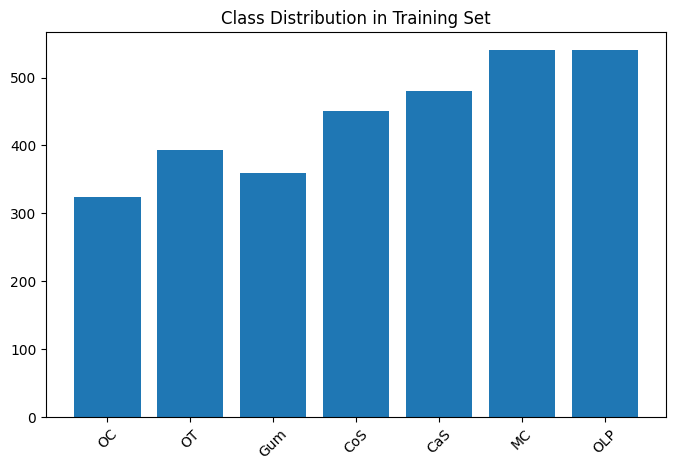

In [4]:
# ==============================
# STEP 3: Visualize Class Distribution
# ==============================
import matplotlib.pyplot as plt

def count_images_per_class(directory):
    counts = {}
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len(os.listdir(cls_path))
    return counts

train_counts = count_images_per_class(train_dir)
plt.figure(figsize=(8,5))
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.show()

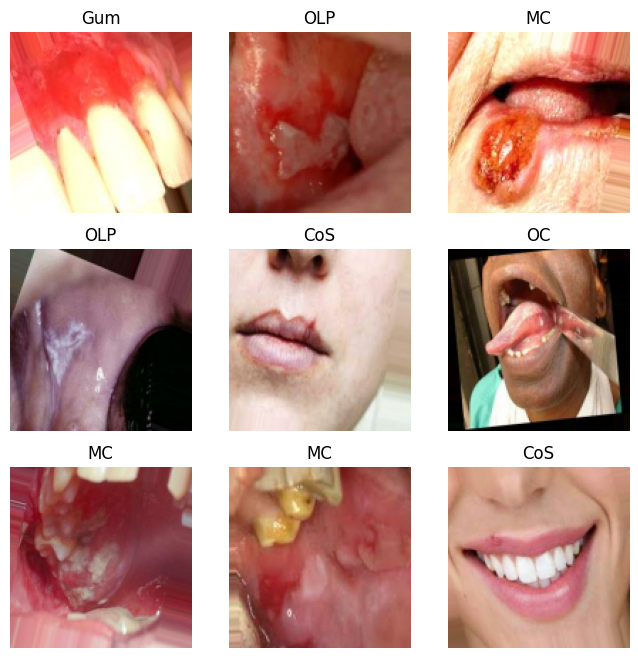

In [5]:
# ==============================
# STEP 4: Show Sample Images Before Augmentation
# ==============================
plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

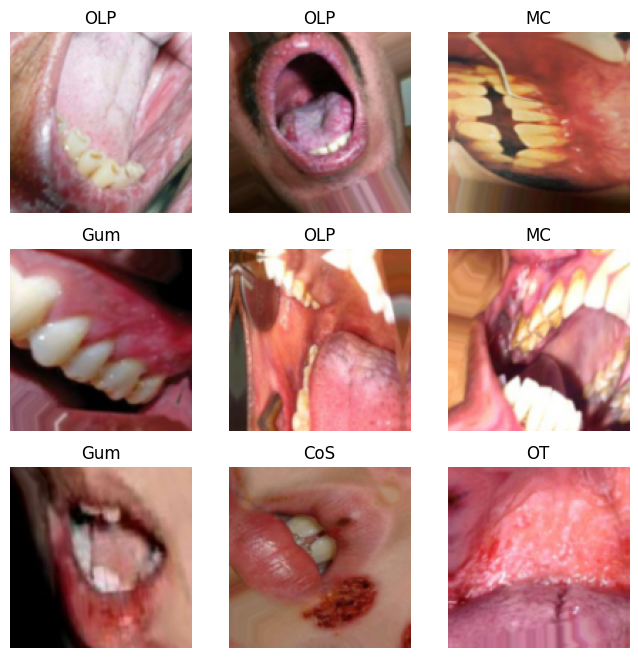

In [6]:
# ==============================
# STEP 5: Data Augmentation Layer
# ==============================
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
], name="data_augmentation")

plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_img = data_augmentation(images[i])
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_img.numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
# Step 6: Define Model
import keras

# Data augmentation (no input_shape here)
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
], name="data_augmentation")

# Model definition
inputs = keras.Input(shape=(128,128,3))
x = data_augmentation(inputs)
x = keras.layers.Rescaling(1./255)(x)

x = keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(7, activation="softmax")(x)

model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,135 (1.62 MB)

 Trainable params: 423,175 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [9]:
# ==============================
# STEP 7: Train Model with Callbacks
# ==============================
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=15, restore_best_weights=True
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,              # high max, will stop early
    callbacks=callbacks
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.2468 - loss: 2.0182 - val_accuracy: 0.1449 - val_loss: 4.0855 - learning_rate: 0.0010
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.3752 - loss: 1.5983 - val_accuracy: 0.1449 - val_loss: 7.0766 - learning_rate: 0.0010
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.4336 - loss: 1.4636 - val_accuracy: 0.1693 - val_loss: 3.4997 - learning_rate: 0.0010
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.4528 - loss: 1.4183 - val_accuracy: 0.1566 - val_loss: 4.0363 - learning_rate: 0.0010
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.5149 - loss: 1.2969 - val_accuracy: 0.2656 - val_loss: 2.5472 - learning_rate: 0.0010
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.5421 - loss: 1.2360 - val_accuracy: 0.4261 - val_loss: 1.4649 - learning_rate: 0.0010
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.5708 - loss: 1.1360 - val_acc

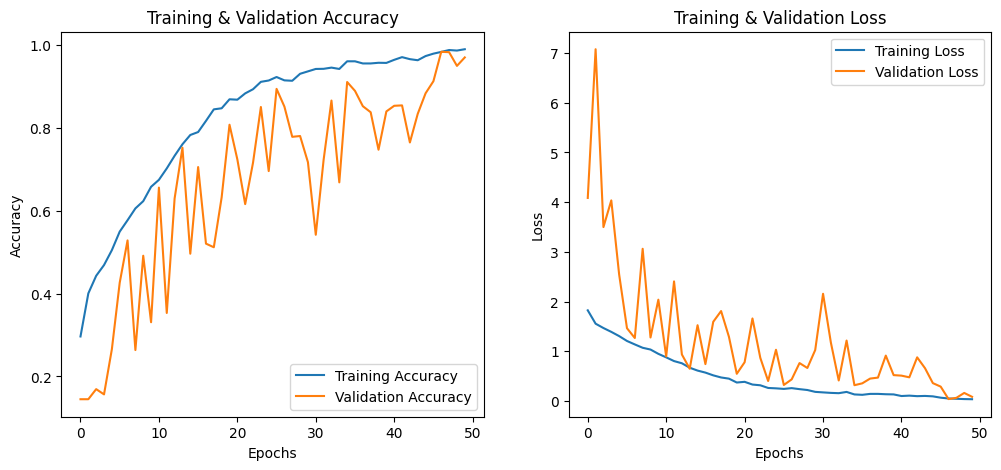

In [10]:
# ==============================
# STEP 8: Plot Accuracy and Loss Curves
# ==============================
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))

# --- Accuracy plot ---
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# --- Loss plot ---
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()


In [11]:
# ==============================
# STEP 9: Evaluate on Test Set
# ==============================
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 405ms/step - accuracy: 0.9850 - loss: 0.0564
✅ Test Accuracy: 0.9835
